In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from functions import *

# Capon

In [2]:
synthetic = True # If true do synthetic data, if false do measured data.

# System parameters
SNR_dB = -10
N_rows = 71
N_cols = 66
array_size = np.array([N_rows, N_cols, 101])

# Subarray
L1 = 20
L2 = 20
L3 = 30
sub_array_size = np.array([L1, L2, L3])
idx_array, idx_n = getSubarray(array_size, sub_array_size, spacing=2)

# Load data
data = loadmat('dev/MeasurementforMiniproject.mat')
if synthetic is True:
    X = data['X_synthetic'][idx_array][:, idx_n]
    
    if SNR_dB is not None:
        X += get_noise(X, SNR_dB)
else:
    X = data['X'][idx_array][:, idx_n]
    
r = data['r'][:, idx_array]
f = data['f'][idx_n]
f0 = data['f0'][0, 0]
tau = data['tau']
true_angles = np.rad2deg(data['smc_param'][0][0][1])
true_angles[true_angles < 0] = true_angles[true_angles < 0] + 360

# Print info
print(f'X: {X.shape}, r: {r.shape}')
print('f:', f.shape)
print('r:', r.shape)
print('Maximum time-delay:', tau[-1] - tau[0])
print('Number of sources:', data['smc_param'][0][0][0])
print('True angles:\n', true_angles)
print('True time-delays:\n', data['smc_param'][0][0][2])

# Spartial smoothing
Ls1 = 9
Ls2 = 9
Ls3 = 15
sub_array_smooth_size = np.array([Ls1, Ls2, Ls3])
RFB = spatialSmoothing(X, sub_array_size, sub_array_smooth_size)
print(RFB.shape)

X: (400, 30), r: (2, 400)
f: (30, 1)
r: (2, 400)
Maximum time-delay: [5.e-07]
Number of sources: [[5]]
True angles:
 [[ 50.88252107]
 [ 34.82704776]
 [164.39983394]
 [272.69385129]
 [ 64.56419748]]
True time-delays:
 [[3.23578932]
 [4.39589382]
 [9.33539943]
 [9.35254152]
 [5.7079572 ]]
(1215, 1215)


In [3]:
idx_sub_array, idx_sub_n = getSubarray(array_size, sub_array_smooth_size, spacing=2)
f = data['f'][idx_sub_n]
r = data['r'][:, idx_sub_array]

# Calculated parameters
samples = len(f)
wave = 3e8 / f0
print('Number of samples:', samples)

# Time-delay parameters
K = 100
tau_max = 5e-7
tau_search = np.linspace(start=0, stop=1, num=K, endpoint=True) * tau_max

# AoA parameters
D = 100
az_search = np.linspace(start=0, stop=2*np.pi, num=D, endpoint=True)

# Power spectrum
Pc = np.zeros((K, D), dtype=complex)
R_inv = np.linalg.inv(RFB)

for i in range(D):
    print(i, '/', D)
    for j in range(K):
        
        mu = delay_response_vector(az_search[i], tau_search[j], r, f, wave)

        Pc[j, i] = 1 / (mu.conj().T @ R_inv @ mu)

Number of samples: 15
0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100


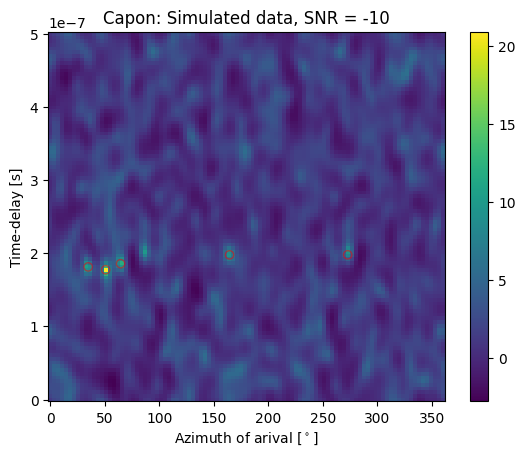

In [4]:
if synthetic is True:
    title = f'Capon: Simulated data, SNR = {SNR_dB}'
    fname = f'capon_{L1}-{L2}-{L3}_{Ls1}-{Ls2}-{Ls3}.pdf'
else:
    title = 'Capon: Measured data'
    fname = f'capon_{L1}-{L2}-{L3}_{Ls1}-{Ls2}-{Ls3}_meas.pdf'

plotter(az_search, tau_search, Pc, data, title) # Add fname as arg to save fig